## **Time series forecasting (using Facebook Prophet): Air quality (Bangkok)**

* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/timeseries_air_quality.ipynb
* data source: https://aqicn.org/data-platform/register/
* Facebook Prophet: https://facebook.github.io/prophet/
* further reading: https://www.analyticsvidhya.com/blog/2018/05/
* generate-accurate-forecasts-facebook-prophet-python-r/

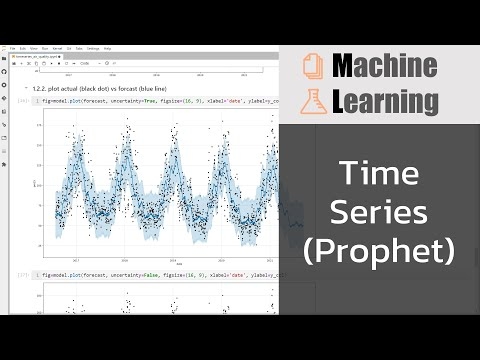

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('rNjMs3sn_QM', width=720, height=405)

In [3]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pd.Timestamp.now()
# pd.Timestamp.now().strftime('%Y-%m-%d')

Python  version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
pandas  version: 1.1.5
numpy   version: 1.19.5
seaborn version: 0.11.1


Timestamp('2021-05-18 18:10:57.790264')

## **read and preprocess data**

In [5]:
data_url='https://github.com/prasertcbs/basic-dataset/raw/master/bangkok-air-quality.csv'
data=pd.read_csv(data_url, parse_dates=['date'], skipinitialspace=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2021-03-01,93.0,30.0,8.0,6.0,1.0,NaN
1,2021-03-02,68.0,27.0,7.0,5.0,1.0,NaN
2,2021-03-03,58.0,37.0,13.0,9.0,1.0,NaN
3,2021-03-04,74.0,35.0,13.0,6.0,NaN,NaN
4,2021-03-05,72.0,38.0,15.0,6.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2015-03-15,NaN,NaN,23.0,13.0,3.0,9.0
2620,2014-11-30,NaN,NaN,40.0,36.0,4.0,11.0
2621,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
2622,2014-01-26,NaN,NaN,54.0,53.0,6.0,18.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2624 non-null   datetime64[ns]
 1   pm25    1680 non-null   float64       
 2   pm10    2609 non-null   float64       
 3   o3      2610 non-null   float64       
 4   no2     2611 non-null   float64       
 5   so2     1877 non-null   float64       
 6   co      963 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 143.6 KB


In [7]:
data=data.sort_values('date').reset_index(drop=True).copy()
data

,date,pm25,pm10,o3,no2,so2,co
0,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
1,2014-01-01,NaN,84.0,90.0,48.0,5.0,16.0
2,2014-01-02,NaN,84.0,119.0,63.0,7.0,14.0
3,2014-01-03,NaN,103.0,95.0,57.0,7.0,13.0
4,2014-01-04,NaN,101.0,52.0,34.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [8]:
y_col='pm25'

In [9]:
data.dropna(subset=[y_col], inplace=True)
data

,date,pm25,pm10,o3,no2,so2,co
938,2016-07-30,61.0,19.0,17.0,15.0,8.0,6.0
939,2016-07-31,68.0,24.0,25.0,13.0,7.0,6.0
940,2016-08-01,60.0,20.0,26.0,14.0,2.0,6.0
941,2016-08-02,68.0,25.0,21.0,14.0,7.0,6.0
942,2016-08-03,70.0,26.0,23.0,16.0,2.0,6.0
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [10]:
df=data[['date', y_col]]
df.columns=['ds', 'y']
df

,ds,y
938,2016-07-30,61.0
939,2016-07-31,68.0
940,2016-08-01,60.0
941,2016-08-02,68.0
942,2016-08-03,70.0
...,...,...
2619,2021-03-10,98.0
2620,2021-03-11,111.0
2621,2021-03-12,101.0
2622,2021-03-13,96.0


## **Time Series Forecasting with Prophet**

In [11]:
# install facebook prophet (Time Series analysis)
# !conda install -c conda-forge fbprophet
# !pip install fbprophet

In [12]:
from fbprophet import Prophet

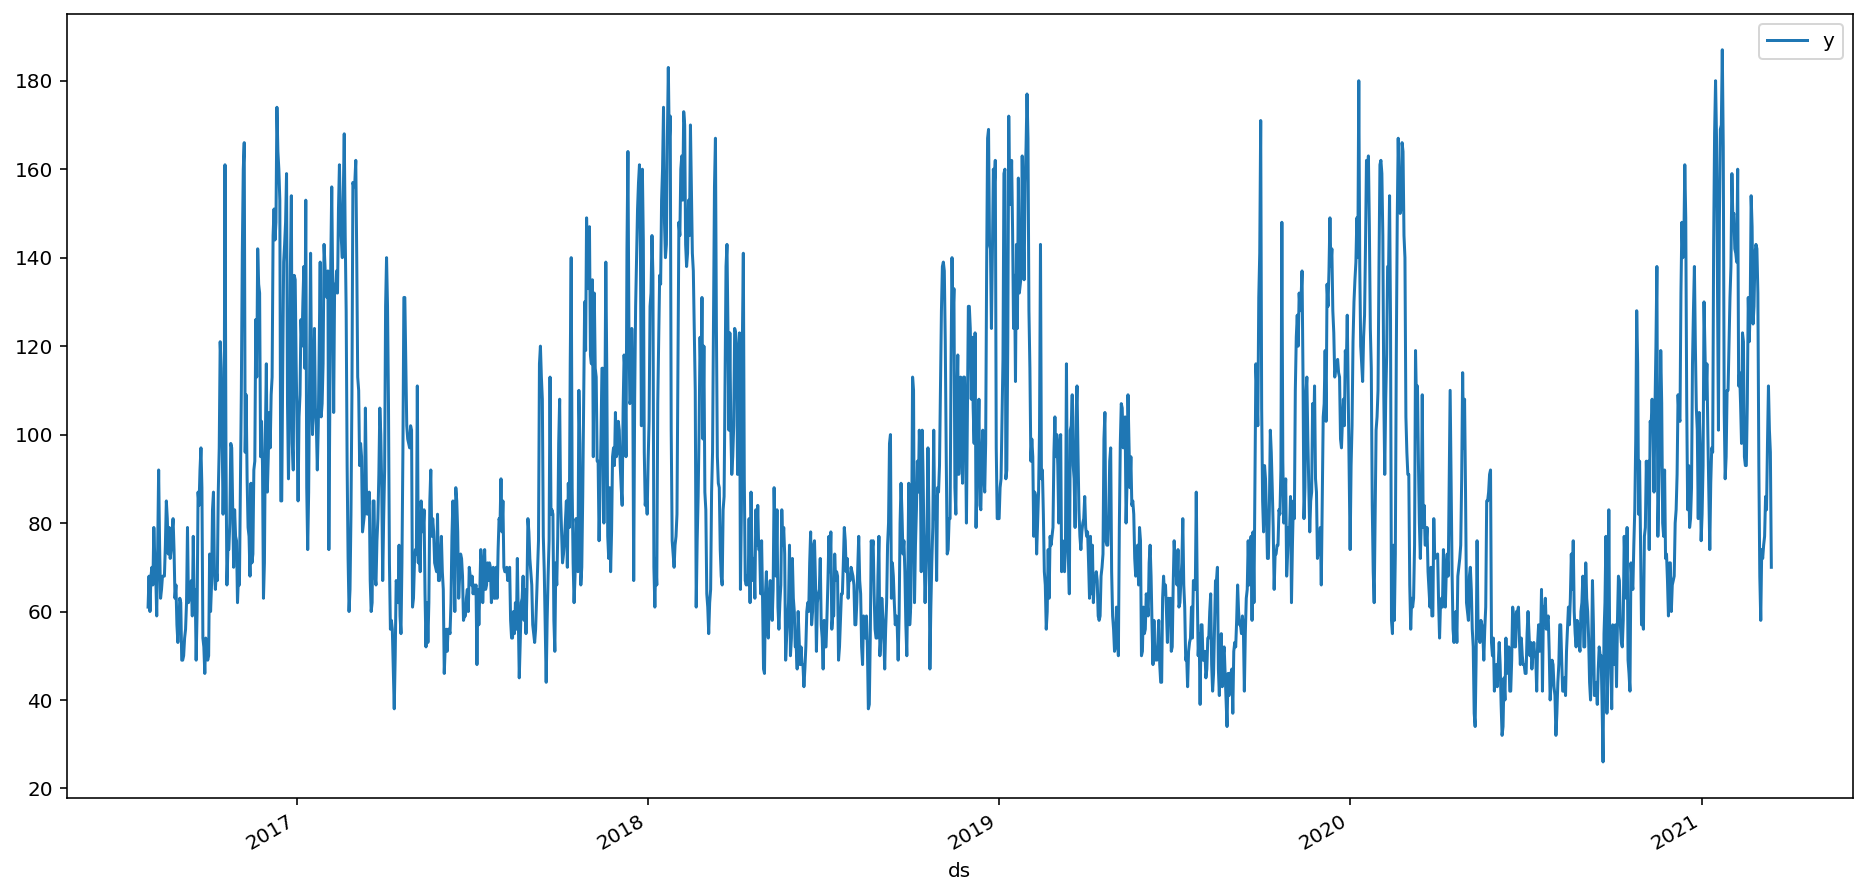

In [13]:
df.set_index('ds').plot(figsize=(16, 8));

In [14]:
model=Prophet()

In [15]:
model.__dict__

{'changepoint_prior_scale': 0.05,
 'changepoint_range': 0.8,
 'changepoints': None,
 'changepoints_t': None,
 'component_modes': None,
 'country_holidays': None,
 'daily_seasonality': 'auto',
 'extra_regressors': OrderedDict(),
 'fit_kwargs': {},
 'growth': 'linear',
 'history': None,
 'history_dates': None,
 'holidays': None,
 'holidays_prior_scale': 10.0,
 'interval_width': 0.8,
 'logistic_floor': False,
 'mcmc_samples': 0,
 'n_changepoints': 25,
 'params': {},
 'seasonalities': OrderedDict(),
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10.0,
 'specified_changepoints': False,
 'stan_backend': <fbprophet.models.PyStanBackend at 0x7f11b558df10>,
 'stan_fit': None,
 'start': None,
 't_scale': None,
 'train_component_cols': None,
 'train_holiday_names': None,
 'uncertainty_samples': 1000,
 'weekly_seasonality': 'auto',
 'y_scale': None,
 'yearly_seasonality': 'auto'}

In [16]:
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
df.tail()

,ds,y
2619,2021-03-10,98.0
2620,2021-03-11,111.0
2621,2021-03-12,101.0
2622,2021-03-13,96.0
2623,2021-03-14,70.0


## **make_future_dataframe เพื่อใช้ในการทำ model.forecast ไปในอนาคต เช่น 180 วันจากข้อมูล**

In [18]:
future=model.make_future_dataframe(periods=180, freq='D')
future.tail()

,ds
1855,2021-09-06
1856,2021-09-07
1857,2021-09-08
1858,2021-09-09
1859,2021-09-10


In [19]:
future.head()

,ds
0,2016-07-30
1,2016-07-31
2,2016-08-01
3,2016-08-02
4,2016-08-03


In [20]:
forecast=model.predict(future)

In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-30,89.373681,38.012935,91.416183,89.373681,89.373681,-24.630607,-24.630607,-24.630607,0.033355,0.033355,0.033355,-24.663962,-24.663962,-24.663962,0.0,0.0,0.0,64.743074
1,2016-07-31,89.374122,36.499348,89.320622,89.374122,89.374122,-26.394379,-26.394379,-26.394379,-1.411412,-1.411412,-1.411412,-24.982967,-24.982967,-24.982967,0.0,0.0,0.0,62.979743
2,2016-08-01,89.374563,36.463436,92.285877,89.374563,89.374563,-24.998421,-24.998421,-24.998421,0.279201,0.279201,0.279201,-25.277622,-25.277622,-25.277622,0.0,0.0,0.0,64.376142
3,2016-08-02,89.375005,37.876962,92.081759,89.375005,89.375005,-24.452126,-24.452126,-24.452126,1.088331,1.088331,1.088331,-25.540456,-25.540456,-25.540456,0.0,0.0,0.0,64.922879
4,2016-08-03,89.375446,38.733336,91.559400,89.375446,89.375446,-24.852156,-24.852156,-24.852156,0.912912,0.912912,0.912912,-25.765068,-25.765068,-25.765068,0.0,0.0,0.0,64.523290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,2021-09-06,75.590369,25.057471,78.011909,75.491485,75.699709,-25.940091,-25.940091,-25.940091,0.279201,0.279201,0.279201,-26.219292,-26.219292,-26.219292,0.0,0.0,0.0,49.650279
1856,2021-09-07,75.580672,24.294726,79.729816,75.480555,75.691904,-24.921227,-24.921227,-24.921227,1.088331,1.088331,1.088331,-26.009558,-26.009558,-26.009558,0.0,0.0,0.0,50.659444
1857,2021-09-08,75.570974,23.283925,78.463509,75.469503,75.682862,-24.787467,-24.787467,-24.787467,0.912912,0.912912,0.912912,-25.700379,-25.700379,-25.700379,0.0,0.0,0.0,50.783507
1858,2021-09-09,75.561276,21.891339,78.961317,75.458941,75.673817,-25.707943,-25.707943,-25.707943,-0.420396,-0.420396,-0.420396,-25.287546,-25.287546,-25.287546,0.0,0.0,0.0,49.853334


In [22]:
df

,ds,y
938,2016-07-30,61.0
939,2016-07-31,68.0
940,2016-08-01,60.0
941,2016-08-02,68.0
942,2016-08-03,70.0
...,...,...
2619,2021-03-10,98.0
2620,2021-03-11,111.0
2621,2021-03-12,101.0
2622,2021-03-13,96.0


In [23]:
dfcst=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
dfcst

,ds,yhat,yhat_lower,yhat_upper
0,2016-07-30,64.743074,38.012935,91.416183
1,2016-07-31,62.979743,36.499348,89.320622
2,2016-08-01,64.376142,36.463436,92.285877
3,2016-08-02,64.922879,37.876962,92.081759
4,2016-08-03,64.523290,38.733336,91.559400
...,...,...,...,...
1855,2021-09-06,49.650279,25.057471,78.011909
1856,2021-09-07,50.659444,24.294726,79.729816
1857,2021-09-08,50.783507,23.283925,78.463509
1858,2021-09-09,49.853334,21.891339,78.961317


In [24]:
dt=pd.merge(df, dfcst, left_on='ds', right_on='ds')
dt

,ds,y,yhat,yhat_lower,yhat_upper
0,2016-07-30,61.0,64.743074,38.012935,91.416183
1,2016-07-31,68.0,62.979743,36.499348,89.320622
2,2016-08-01,60.0,64.376142,36.463436,92.285877
3,2016-08-02,68.0,64.922879,37.876962,92.081759
4,2016-08-03,70.0,64.523290,38.733336,91.559400
...,...,...,...,...,...
1675,2021-03-10,98.0,84.563043,57.085173,111.589317
1676,2021-03-11,111.0,82.068028,54.153354,108.692015
1677,2021-03-12,101.0,80.939310,53.979532,109.148141
1678,2021-03-13,96.0,80.492039,54.004375,108.514076


In [25]:
dt.shape

(1680, 5)

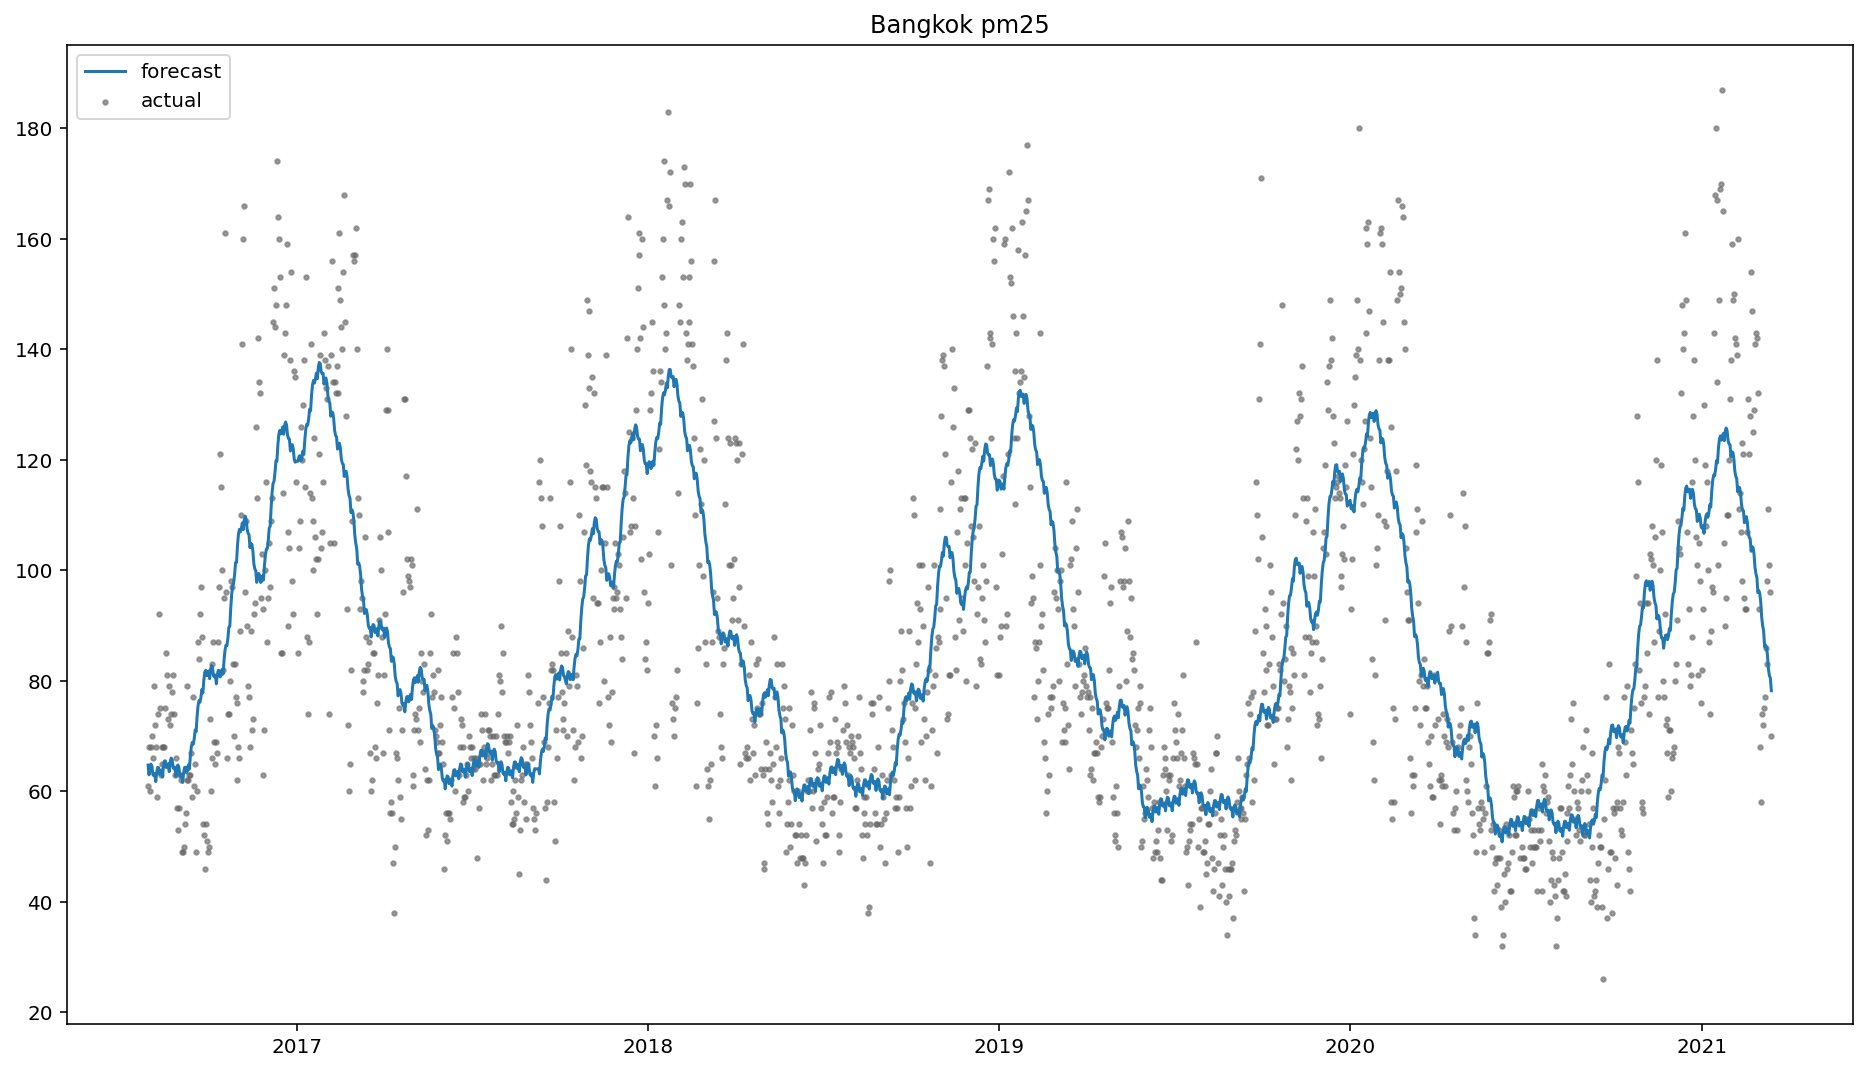

In [26]:
plt.figure(figsize=(16,9))
plt.scatter(dt['ds'], dt['y'], color='.4', label='actual', s=5, alpha=.6)
plt.plot(dt['ds'], dt['yhat'], label='forecast')
plt.title(f'Bangkok {y_col}')
plt.legend();

## **plot actual (black dot) vs forcast (blue line)**

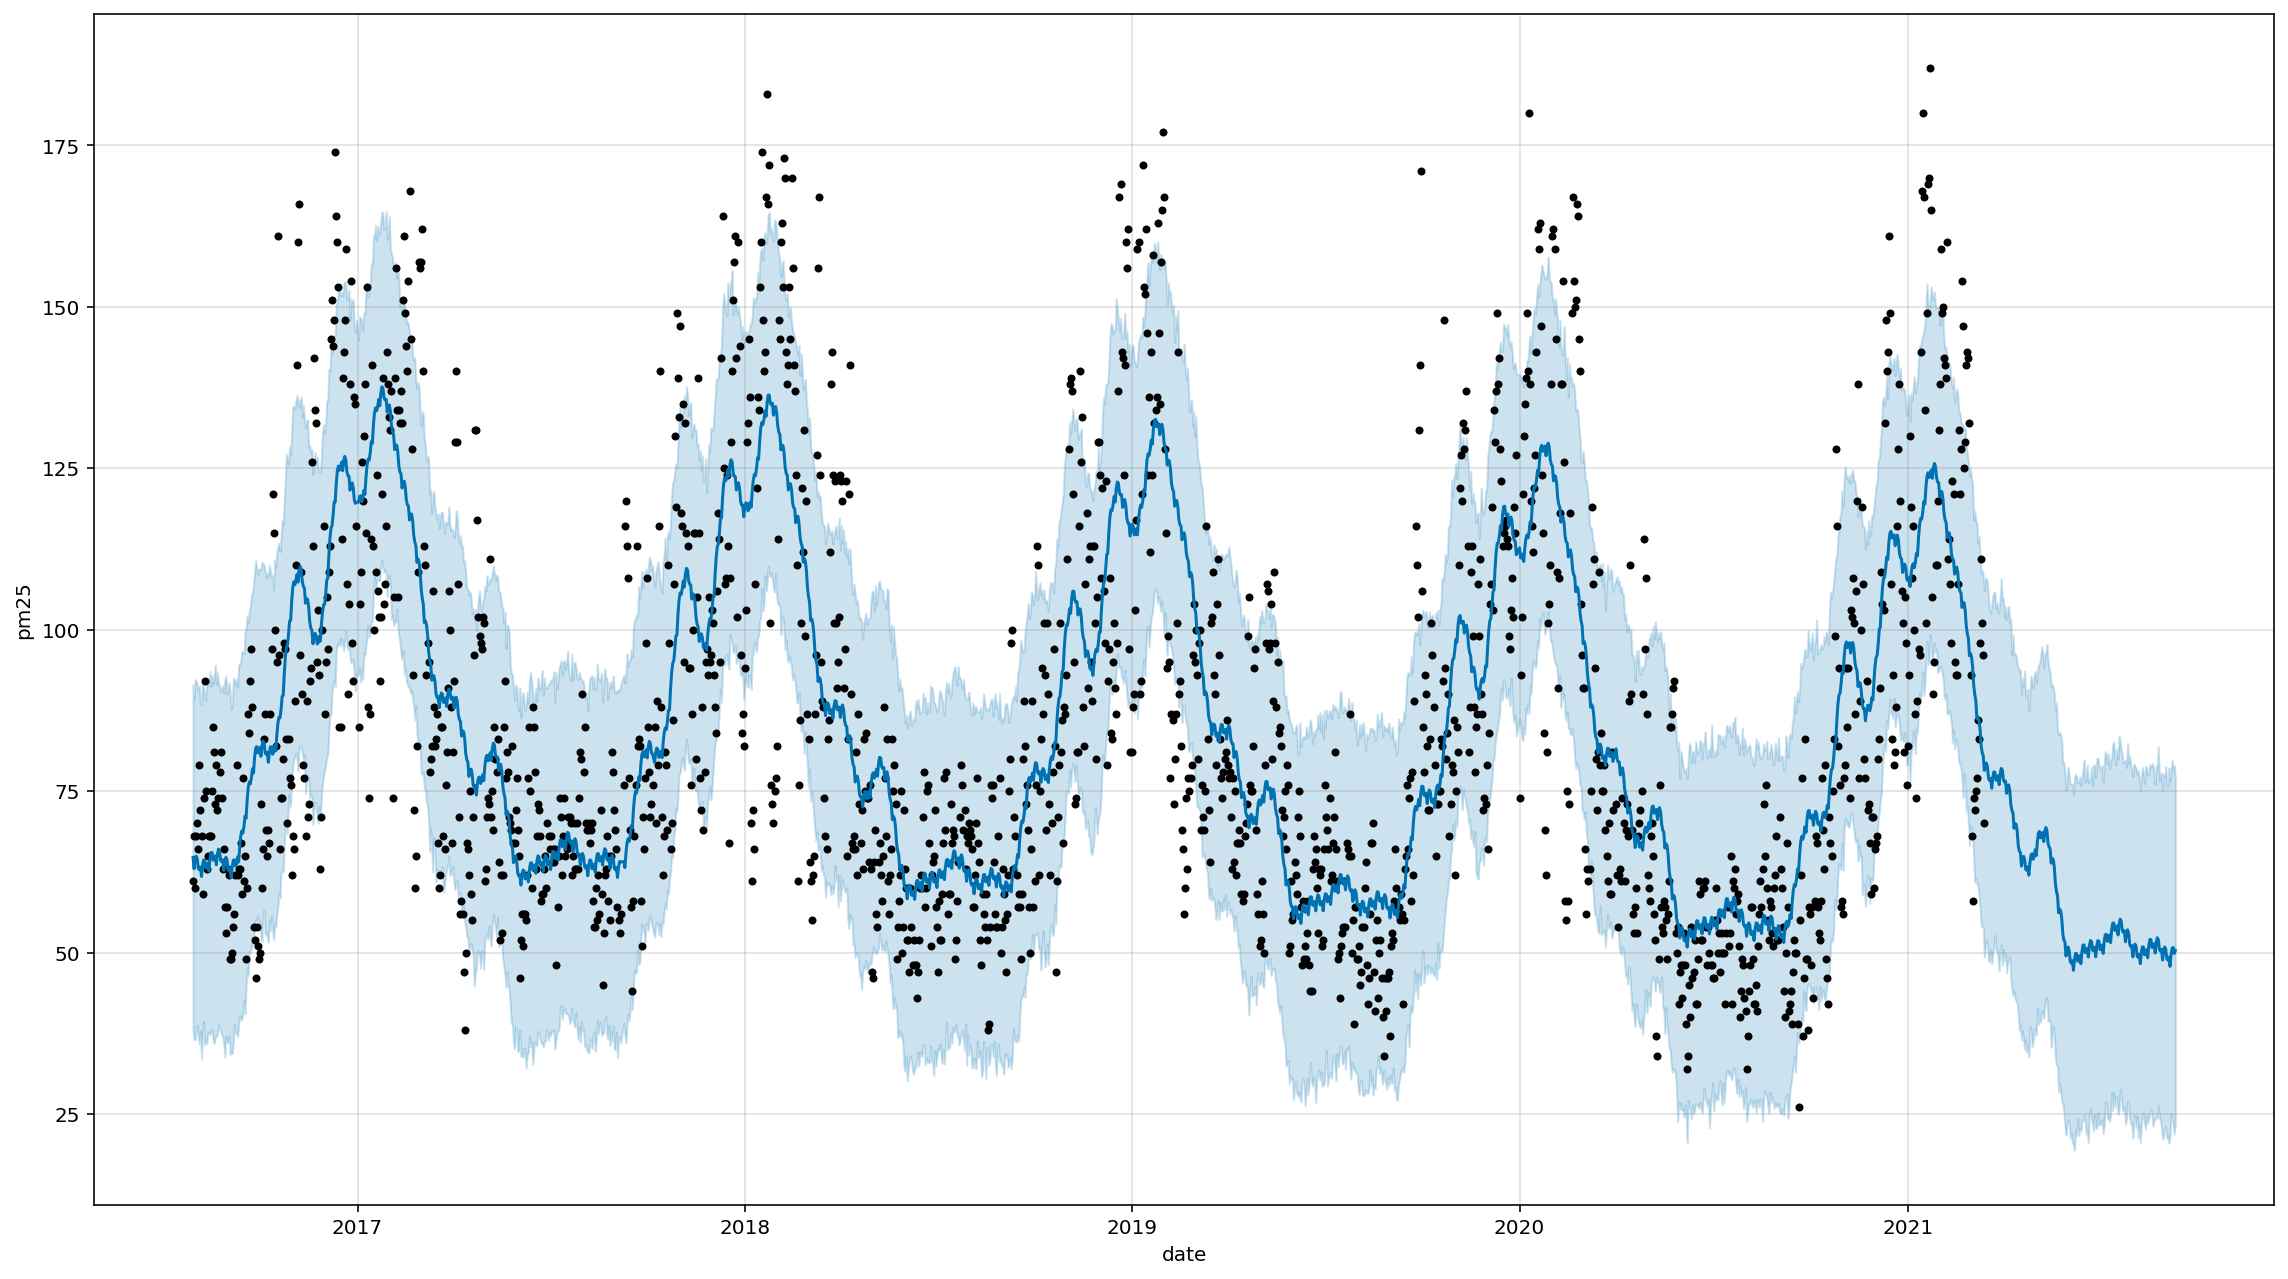

In [27]:
fig=model.plot(forecast, uncertainty=True, figsize=(16, 9), xlabel='date', ylabel=y_col)

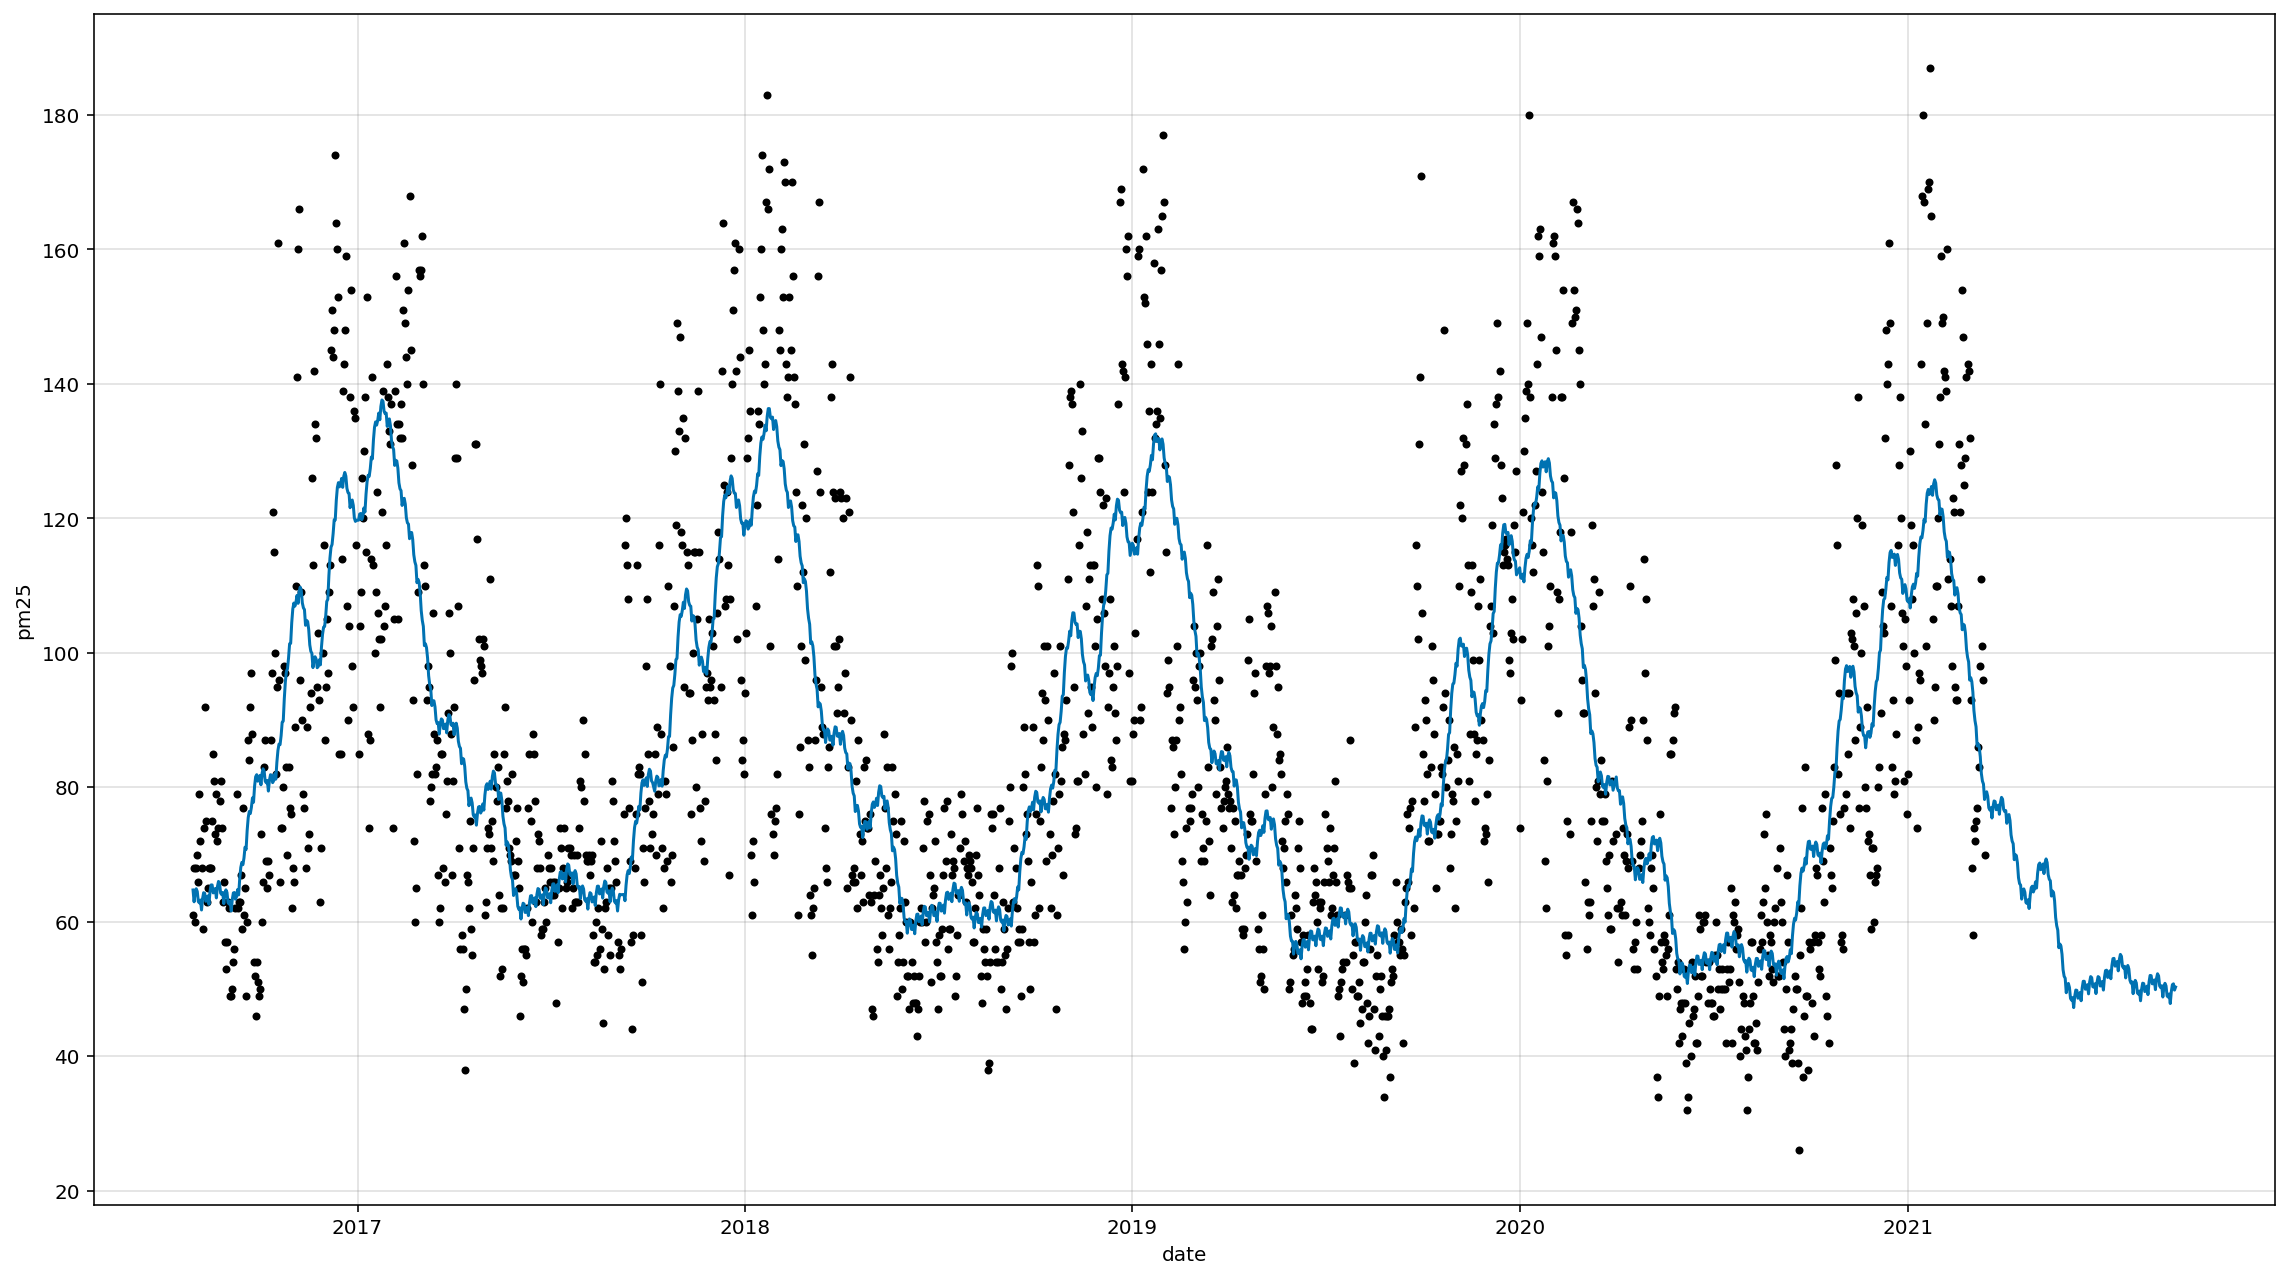

In [28]:
fig=model.plot(forecast, uncertainty=False, figsize=(16, 9), xlabel='date', ylabel=y_col)

v

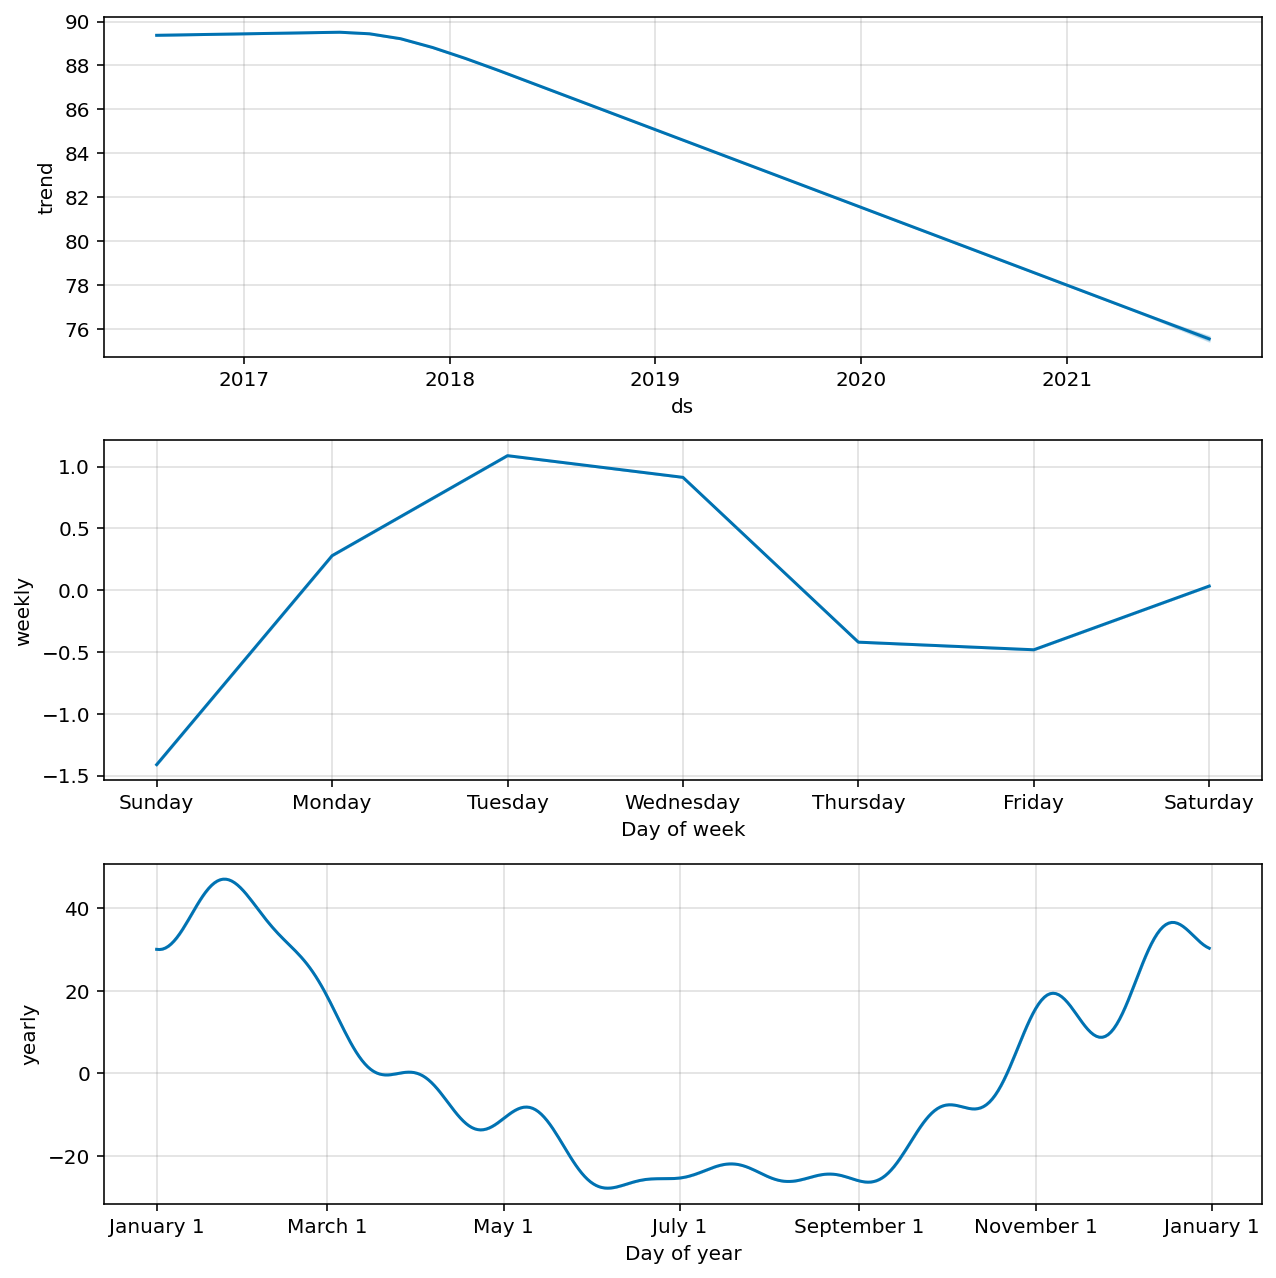

In [29]:
fig=model.plot_components(forecast)